# Arytmetyka i algebra dla kryptografii

In [84]:
import math
import random
import matplotlib.pyplot as plt

## Testowanie pierwszości

Głównym tematem dzisiejszych laboratoriów będą **testy pierwszości** (primality tests), tj. algorytmy sprawdzania, czy zadana liczba jest liczbą pierwszą. Jakkolwiek istnieją asymptotycznie wydajne *deterministyczne* algorytmy rozwiązujące ten problem, w praktyce są one znacznie wolniejsze i bardziej skomplikowane od algorytmów *probabilistycznych*, na których się skupimy.

Jako referencyjny test pierwszości wykorzystamy prosty algorytm sprawdzający po kolei, czy liczby naturalne z zakresu $2,...,\lfloor\sqrt{n}\rfloor$ są dzielnikami $n$.

In [85]:
def prime_naive(n):
    if n < 2:
        return False

    m = math.isqrt(n)
    for i in range(2, m + 1):
        if n % i == 0:
            return False

    return True

By przyspieszyć nieco obliczenia w pozostałych ćwiczeniach, możemy zapamiętać wyniki dla pewnego początkowego zakresu liczb.

In [86]:
SIZE = 1000000
IS_PRIME = [prime_naive(n) for n in range(SIZE)]
PRIMES = [n for n in range(SIZE) if IS_PRIME[n]]
SET_OF_PRIMES = set(PRIMES)

In [87]:
def prime_ref(n):
    """
    Referencyjny test pierwszości, z którym porównywać będziemy inne metody.
    """
    if n < SIZE:
        return IS_PRIME[n]
    else:
        return prime_naive(n)

### Test Fermata

Małe twierdzenie Fermata mówi, że jeśli $p$ jest liczbą pierwszą i $0 < a < p$, to $a^{p-1} \equiv 1 \pmod p$. Fakt ten stanowi podstawę *testu pierwszości Fermata*. W teście tym by sprawdzić, czy dane $n$ jest liczbą pierwszą, losujemy $0 < a < p$ i sprawdzamy, czy $a^{n-1} \equiv 1 \pmod n$. Jeśli nie, możemy z pewnością stwierdzić, że $n$ nie jest liczbą pierwszą. Jeśli tak, to $n$ może być liczbą pierwszą (ale nie musi).

Test Fermata nie daje nam pewności, że liczba, która go pomyślnie przeszła jest liczbą pierwszą. By zwiększyć wiarygodność wyniku pozytywnego, możemy wykonać więcej niż jedną iterację, tzn. wylosować kilka wartości $a$. Jeśli test nie przejdzie dla którejkolwiek z nich, $n$ nie jest liczbą pierwszą.

#### Zadanie 1

1. Zaimplementuj test Fermata. Do obliczania $a^k \pmod N$ należy wykorzystać wbudowaną funkcję `pow`, np. `pow(a, k, mod=N)`
2. Przeanalizuj wyniki testu Fermata z jedną iteracją dla wszystkich liczb naturalnych z zakresu $\{1,\ldots,10^6\}$. Ile jest fałszywych wyników pozytywnych, tj. liczb złożonych, dla których test się powiódł? Czy sa jakieś fałszywe wyniki negatywne, tj. liczby pierwsze, dla których test się nie powiódł?
3. Ile iteracji potrzeba, by mieć rozsądne szanse na zero niepoprawnych wyników w teście z punktu 2?
4. Narysuj wykres przedstawiający ilość błędnie sklasyfikowanych liczb w teście z punktu 2 w zależności od liczby iteracji testu Fermata. Użyj skali logarytmicznej dla osi pionowej.

#### Rozwiązanie

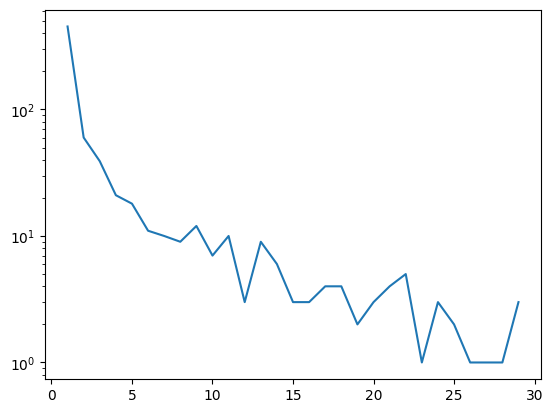

In [88]:
def fermat_test(n, k=5):
    if n < 2:
        return False
    for _ in range(k):
        a = random.randint(1, n - 1)
        if pow(a, n - 1, n) != 1:
            return False
    return True


results = {}
for k in range(1, 30):
    fermat_results = set([n for n in range(SIZE) if fermat_test(n, k)])
    false_positives = fermat_results - SET_OF_PRIMES
    results[k] = len(false_positives)

plt.semilogy(list(results.keys()), list(results.values()))

### Test Millera-Rabina

W teście Millera-Rabina poza małym twierdzeniem Fermata wykorzystujemy również inną własność liczb pierwszych: jeśli $n$ jest liczbą pierwszą, to $\mathbb{Z}/n\mathbb{Z}$ jest ciałem, a więc wielomiany stopnia $q$ mają w nim co najwyżej $q$ pierwiastków. W szczególności, jeśli $n$ jest liczbą pierwszą $\neq 2$, równanie $x^2 \equiv 1 \pmod n$ ma dokładnie dwa rozwiązania: $1$ oraz $-1 \equiv n - 1 \pmod n$.

Niech $n - 1 = 2^s d$, $d$ nieparzyste. Z małego twierdzenia Fermata wiemy, że dla $0 < a < n$ zachodzi $a^{2^s d} = a^{n-1} \equiv 1 \pmod n$. Jako, że $a^{2^s d} = \left(a^{2^{s-1}d}\right)^2$, to $a^{2^{s-1}d}$ jest jednym z rozwiązań równania $x^2 \equiv 1 \pmod n$, a zatem są dwie możliwości:

- $a^{2^{s-1}d} \equiv -1 \pmod n$, albo
- $a^{2^{s-1}d} \equiv 1 \pmod n$

Aplikując powyższe rozumowanie do przypadku $a^{2^{s-1}d} \equiv 1 \pmod n$, widzimy że $a^{2^{s-2}d} \equiv \pm 1 \pmod n$ i tak dalej aż do $a^d \equiv \pm 1 \pmod n$. Stąd, albo $a^d \equiv 1 \pmod n$, albo któreś z $a^d, a^{2d}, a^{4d}, \ldots, a^{2^{s-1}d}$ jest równe $-1 \pmod n$.

#### Algorytm

Na podstawie tej własności liczby pierwszej możemy zbudować następujący algorytm testujący pierwszość:

1. znajdź $s$, $d$ takie, że $n -1 = 2^s d$, $d$ nieparzyste
2. powtórz $k$ razy:
    - wylosuj $2 \leq a \leq n - 2$
    - $x \gets a^d \pmod n$
    - jeśli $x \equiv 1 \pmod n$, zakończ iterację (2)
    - powtórz $s$ razy:
        - jeśli $x \equiv -1 \pmod n$, zakończ iterację (2)
        - $x \gets x^2 \pmod n$
    - zwróć "liczba złożona"
3. żaden z testów nie wykrył złożoności, zwróć "liczba pierwsza"

#### Zadanie 2

1. Zaimplementuj test Millera-Rabina.
2. Przeprowadź dla testu Millera-Rabina analizę analogiczną do tej z Zadania 1 (punkty 2-4). Porównaj wyniki obu metod.

#### Rozwiązanie

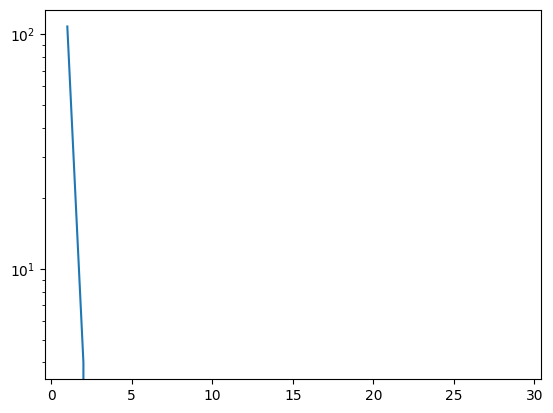

In [89]:
def miller_rabin_test(n, k=5):
    if n < 2:
        return False
    if n in (2, 3):
        return True
    if n % 2 == 0:
        return False

    r = 0
    s = n - 1
    while s % 2 == 0:
        r += 1
        s //= 2

    for _ in range(k):
        a = random.randint(2, n - 2)
        x = pow(a, s, n)
        if x == 1 or x == n - 1:
            continue
        for _ in range(r - 1):
            x = pow(x, 2, n)
            if x == n - 1:
                break
        else:
            return False
    return True


results = {}
for k in range(1, 30):
    miller_rabin_results = set([n for n in range(SIZE) if miller_rabin_test(n, k)])
    false_positives = miller_rabin_results - SET_OF_PRIMES
    results[k] = len(false_positives)

plt.semilogy(list(results.keys()), list(results.values()))

## Generowanie liczb pierwszych

### Duże liczby pierwsze dla kryptografii

W swojej książce "Applied Cryptography" Bruce Schneier proponuje następujący algorytm generowania $n$-bitowych liczb pierwszych:

1. Wygeneruj losową liczbę $n$-bitową
2. Ustaw pierwszy i ostatni bit na $1$ (by zapewnić że jest duża i nieparzysta)
3. Sprawdź, czy wygenerowana liczba jest podzielna przez małe liczby pierwsze, np. wszystkie mniejsze niż $2000$
4. Przeprowadź dla wygenerowanej liczby test Millera-Rabina z $5$ iteracjami
5. Jeśli wygenerowana liczba nie przeszła któregoś z testów (3) i (4), wróć do (1)

#### Zadanie 3

1. Zaimplementuj opisany powyżej schemat generacji liczb pierwszych. Do generacji losowej liczby $k$-bitowej można wykorzystać funkcję `getrandbits` z modułu `random`.
2. Wygeneruj przy jego pomocy liczbę pierwszą o rozmiarze 2048 bitów

#### Rozwiązanie

In [90]:
primes_below_2000 = 0
while PRIMES[primes_below_2000] < 2000:
    primes_below_2000 += 1

def generate_large_prime(bits):
    while True:
        n = random.getrandbits(bits) | (1 << (bits - 1)) | 1
        for p in PRIMES[:primes_below_2000]:
            if n % p == 0 and n != p:
                break
        else:
            if miller_rabin_test(n, 5):
                return n


print(generate_large_prime(2048))

30555923594727073538921863266479382167642911547095184553539034803743777553549857307569731254800483937038731482712833342498371536327043617463262831381440355060938484514991571241465179311901079776401497839188827670179900960051813339926213660983233406179489164433042467356198007269166688051974013719436816250418302188307013815507563962633178115799813021047826014142922224605768550517530085493013971422447643059215286526209014257224719427003537262012261948520678520574122175205891034276772566058428794455854969683656648965653536240635653274115162406744547194243978422193766066757282041185220029928299779513490692163481781


### Jeszcze większe liczby pierwsze dla przyjemności

Największa znana obecnie ludzkości liczba pierwsza to $2^{136279841} - 1$, posiadająca ponad 40 milionów cyfr dziesiętnych. Podobnie jak większość największych znanych liczb pierwszych, jest ona **liczbą Mersenne'a**, tj. ma postać
$$
M_n = 2^n - 1
$$
dla pewnego $n$. Nie wszystkie takie liczby są liczbami pierwszymi - jeśli $M_n$ jest liczbą pierwszą, to $n$ też musi być liczbą pierwszą, ale nie jest to warunek wystarczający - np. $M_{11} = 2047 = 23 \times 89$. Dla liczb Mersenne'a istnieją niemniej specjalne metody testowania pierwszości znacznie bardziej wydajne niż testy pierwszości ogólnego przeznaczenia. Najbardziej wydajną znaną metodą jest **test Lucasa-Lehmera**.

Test Lucasa-Lehmera działa następująco: dla zadanej nieparzystej liczby pierwszej $p$ konstruujemy rekurencyjnie ciąg $S_k$ tak, że

- $S_0 = 4$
- $S_k = S_{k-1}^2 - 2$

Wówczas $M_p = 2^p - 1$ jest liczbą pierwszą wtedy i tylko wtedy, gdy $S_{p-2} \equiv 0 \pmod {M_p}$

#### Zadanie 4

1. Zaimplementuj test Lucasa-Lehmera
2. Sprawdź, czy $M_3$, $M_5$, $M_{17}$, $M_{23}$, $M_{41}$, $M_{61}$, $M_{109}$, $M_{127}$, $M_{2459}$, $M_{3217}$ są liczbami pierwszymi
3. Porównaj czas działania testu Lucasa-Lehmera do czasu działania pojedynczej iteracji testu Millera-Rabina dla $M_{23209}$
4. (**dodatkowe**) Spróbuj wyliczyć jak największą liczbę pierwszą w czasie dostępnym na laboratorium. *Uwaga*: algorytm można przyspieszyć zamieniając dzielenie modulo $M_p$ na operacje binarne korzystając z tożsamości $k \equiv (k \mod 2^p) + \lfloor k / 2^p \rfloor$ - szczegóły [na Wikipedii](https://en.wikipedia.org/wiki/Lucas%E2%80%93Lehmer_primality_test)

In [91]:
TO_TEST = [3, 5, 17, 23, 41, 61, 109, 127, 2459, 3217]

#### Rozwiązanie

In [ ]:
def lucas_lehmer_test(p):
    S = 4
    M = (1 << p) - 1
    for _ in range(p - 2):
        S = S * S - 2
        S = ((S % (1 << p)) + (S >> p)) % M

    return S == 0

for p in TO_TEST:
    if lucas_lehmer_test(p):
        print(f"2^{p}-1 is prime", flush=True)
    else:
        print(f"2^{p}-1 is composite", flush=True)

from time import time

start = time()
miller_rabin_test(1 << 23209, 1)
print(f"Miller-Rabin took {time() - start} seconds")
start = time()
lucas_lehmer_test(23209)
print(f"Lucas-Lehmer took {time() - start} seconds")

for i in range(len(PRIMES)):
    if lucas_lehmer_test(PRIMES[i]):
        print(f"Found that 2^{PRIMES[i]}-1 is prime", flush=True)



2^3-1 is prime
2^5-1 is prime
2^17-1 is prime
2^23-1 is composite
2^41-1 is composite
2^61-1 is prime
2^109-1 is composite
2^127-1 is prime
2^2459-1 is composite
2^3217-1 is prime
Miller-Rabin took 8.320808410644531e-05 seconds
Lucas-Lehmer took 17.339525938034058 seconds
Found that 2^3-1 is prime
Found that 2^5-1 is prime
Found that 2^7-1 is prime
Found that 2^13-1 is prime
Found that 2^17-1 is prime
Found that 2^19-1 is prime
Found that 2^31-1 is prime
Found that 2^61-1 is prime
Found that 2^89-1 is prime
Found that 2^107-1 is prime
Found that 2^127-1 is prime
Found that 2^521-1 is prime
Found that 2^607-1 is prime
Found that 2^1279-1 is prime
Found that 2^2203-1 is prime
Found that 2^2281-1 is prime
Found that 2^3217-1 is prime
Found that 2^4253-1 is prime
Found that 2^4423-1 is prime
Found that 2^9689-1 is prime
Found that 2^9941-1 is prime
Found that 2^11213-1 is prime


## Elementy odwrotne w $(\mathbb{Z}/n\mathbb{Z})^\times$

Standardowy algorytm Euklidesa pozwala nam obliczyć największy wspólny dzielnik liczb $a$, $b$. Jego działanie sprowadza się do obliczenia ciągu reszt z dzielenia:
$$
\begin{aligned}
r_0 &= a, r_1 = b \\
r_2 &= r_0 \mod r_1\\
r_3 &= r_1 \mod r_2\\
\ldots & \\
r_n &= r_{n-2} \mod r_{n-1} \\
\ldots &
\end{aligned}
$$
aż do momentu, gdy $r_n = 0$, wówczas $r_{n-1}$ to szukana wartość $d = (a, b)$. Z lematu Bézouta wiemy, że istnieją liczby całkowite $s$, $t$ takie, że $sa + tb = 1$. Rozszerzony algorytm Euklidesa pozwala nam je wyliczyć. Poza ciągiem $\{r_k\}$ obliczamy w nim również ciągi pomocnicze $\{s_k\}$, $\{t_k\}$ o własności
$$
s_k a + t_k b = r_k
$$
W każdej iteracji algorytmu mając dane wartości $s_{k-1}, t_{k-1}, r_{k-1}$ oraz $s_k, t_k, r_k$, możemy obliczyć $s_{k+1}, t_{k+1}, r_{k+1}$ w następupjący sposób. Wiemy, że $r_{k-1} = q r_k + r_{k+1}$ dla pewnego $q$, konkretnie $q = \lfloor r_{k - 1} / r_k\rfloor$. Stąd, $r_{k+1} = r_{k-1} - q r_k$. Skoro zaś
$$
r_{k-1} = s_{k-1} a + t_{k-1} b, \quad r_k = s_k a + t_k b
$$
to również
$$
\begin{aligned}
r_{k+1} &= s_{k-1} a + t_{k-1} b - q(s_k a + t_k b) \\&=
(s_{k-1} - q s_k)a + (t_{k-1} - q t_k) b
\end{aligned}
$$
a zatem możemy przyjąć $s_{k+1} = s_{k-1} - q s_k$ oraz $t_{k+1} = t_{k-1} - q t_k$. Ostatecznie mamy zatem
$$
\begin{aligned}
r_{k+1} &= r_{k-1} - q r_k \\
s_{k+1} &= s_{k-1} - q s_k \\
t_{k+1} &= t_{k-1} - q t_k \\
\end{aligned}
$$

Jeśli $(a, n) = 1$, to mając wyliczone rozszerzonym algorytmem Euklidesa liczby całkowite $s$, $t$ takie, że $sa + tn = 1$, możemy wyliczyć element odwrotny do $a$ w $\mathbb{Z} / n\mathbb{Z}$ jako $a^{-1} \equiv s \pmod n$, jako że $n$ dzieli $sa - 1 = tn$.

#### Zadanie 5

1. Zaimplementuj rozszerzony algorytm Euklidesa wyznaczający dla zadanych $a, b \in \mathbb{Z}$ wartość $(a, b)$ oraz $s, t \in \mathbb{Z}$ takie, że $sa + tb = (a, b)$.
2. Zaimplementuj funkcję znajdującą dla danego $a$ element odwrotny modulo $n$
3. Przetestuj działanie powyższej funkcji dla kilku dużych (np. $1024$ bitowych) modułów.

#### Rozwiązanie

In [ ]:
def extended_euclid(a, b):
    old_r, r = a, b
    old_s, s = 1, 0
    old_t, t = 0, 1
    
    while r != 0:
        quotient = old_r // r
        old_r, r = r, old_r - quotient * r
        old_s, s = s, old_s - quotient * s
        old_t, t = t, old_t - quotient * t
    
    return (old_r, old_s, old_t)

def inverse(a, n):
    a = a % n
    g, s, _ = extended_euclid(a, n)
    if g != 1:
        print(f"a and n arent coprime (gcd({a}, {n}) = {g})")
        return

    return s % n

print(inverse(7, 1 << 1024))

for i in [1 << 10, 1 << 20, 1 << 30]:
    inverse(5, 1 << i)

77043991494099253188398793890958202869341870526098853117184320496171146773786127056875061709603229723337191662802025724710909900920464266782648898845488910447614811467799493689843808400534040336908464122322145329502064578146769806345962761660354530212864504579108413531405962545062735559215152712696096058807
